<a href="https://colab.research.google.com/github/rhiats/timeSeriesForecastSales/blob/main/timeSeries_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time-Series Forecasting of Store Sales**

The dataset contains consecutive transactions from January 1, 2013 to August 15, 2017. The transactions are from the Favorita stores located in Ecuador.

References:

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv

https://www.kaggle.com/learn/time-series

https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/

https://bfi.uchicago.edu/wp-content/uploads/The-Case-of-Ecuador.pdf

https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/timeSeriesStore/input/train.csv", parse_dates=["date"])
df = df.set_index("date")

def nan_num(df):
  """
    Return the number of nans per column in the data set.

  """
  nan_count=df.isnull().sum()
  return nan_count
nan_num(df)

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [3]:
def missingDates(first,last,df):
  """
    Check for missing dates in the dataframe
  """
  return pd.date_range(start = first, end = last ).difference(df.index)

missingDates("2013-01-01","2017-08-15",df)

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [4]:
df.index=df.index.to_period("Q") #Convert to Business quarters period for visualization
df.reset_index(inplace=True)
df['Time'] = np.arange(len(df.index)) #Time Dummy
df.head()

,date,id,store_nbr,family,sales,onpromotion,Time
0,2013Q1,0,1,AUTOMOTIVE,0.0,0,0
1,2013Q1,1,1,BABY CARE,0.0,0,1
2,2013Q1,2,1,BEAUTY,0.0,0,2
3,2013Q1,3,1,BEVERAGES,0.0,0,3
4,2013Q1,4,1,BOOKS,0.0,0,4


**Linear Regression - Influence of Time on Daily Sales**

The Linear Regression model explains 1% of the variance in sales. It is not a good linear predictor of the change in sales prices through the years.

In [5]:
X=df['Time'].to_numpy()
y=df['sales'].to_numpy()
X=X.reshape(-1,1)
y=y.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.0073588375722049015

**Linear Regression Influence of Previous Day's Sales on Next Day's Sales**

Linear Regression explains 0.006% of the variation in the sales data. The sales of consecutive days are not dependent on each other - high sales on Monday do not mean high sales on Tuesday.

In [6]:
df['Sales_Lag_1'] = df['sales'].shift(1)
df.dropna(inplace=True)

X=df['sales'].to_numpy()
y=df['Sales_Lag_1'].to_numpy()
X=X.reshape(-1,1)
y=y.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.0005841652567425415

**Simple Moving Average per Quarter**

The Moving Average is the average sales within a sliding window of 90 days, a quarter, to visuaize the long term changes in sales and minimize the short term fluctuations caused by circumstances like holidays. While the trend appears linear, time only explains 15% of the moving average sales per quarter.

There are steep declines in the average sales during Q1 and Q4 of 2014. During this period the country was in a low inflation period with slow changes in the price of goods. The decline may be attributed to spead of an illness, such as Ebola.  

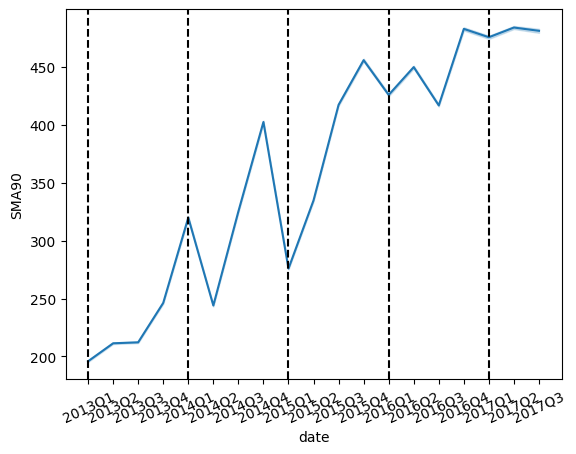

In [7]:
df['SMA90'] = df['sales'].rolling(90).mean()
df.dropna(inplace=True)
plot_df=df[['date','SMA90']]
plot_df['date']=plot_df['date'].astype(str)
sns.lineplot(data=plot_df, x="date", y="SMA90")
plt.xticks(rotation = 25)
xcoords = ['2013Q1', '2014Q1','2015Q1', '2016Q1', '2017Q1']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/timeSeriesStore/output/timeseries_sales.png')

**Linear Regression - Influence of Time on Quarterly Sales**

In [8]:
X=df['Time'].to_numpy()
y=df['SMA90'].to_numpy()
X=X.reshape(-1,1)
y=y.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.1472880410975591

**Seasonality**

There is an additive seasonality in the sales as the median price increases year over year.